In [98]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
from scipy import stats, integrate, optimize, interpolate, linalg

In [99]:
import sim_steady_state as sim
from sim_fake_news import jacobian

Set up same general equilibrium steady state as in lecture 7 notebook:

In [100]:
ss = sim.example_calibration()

B = 4*0.35
tau = ss['r']*B
e = ss['y']

beta_ge = optimize.brentq(lambda beta: sim.steady_state(ss['Pi'], ss['a_grid'],
                                    (1-tau)*e, ss['r'], beta, ss['eis'])['A'] - B, 0.96, 0.995)
ss = sim.steady_state(ss['Pi'], ss['a_grid'], (1-tau)*e, ss['r'], beta_ge, ss['eis'])
ss['A'] - B # check asset market clearing

-1.4503953593703045e-12

# RA monetary response and decomposition

In [101]:
T = 600

In [102]:
r = ss['r']
beta_RA = 1/(1+r)

In [103]:
M_RA = (1-beta_RA)*np.outer(np.ones(T), beta_RA**np.arange(T))
M_RA[:4, :4]

array([[0.00249377, 0.00248755, 0.00248134, 0.00247516],
       [0.00249377, 0.00248755, 0.00248134, 0.00247516],
       [0.00249377, 0.00248755, 0.00248134, 0.00247516],
       [0.00249377, 0.00248755, 0.00248134, 0.00247516]])

In [104]:
C, eis = ss['C'], ss['eis']

In [105]:
U = np.triu(np.ones((T, T))) # upper triangular matrix with all 1s on and above diagonal
U[:4, :4]

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

Choose our shock, which will be unit cut in quarterly real interest rate with quarterly persistence of 0.9. (Note: unlike in some of our notation in the slides, this is just the actual level change $dr$ in the interest rate, not normalized by $(1+r)$.) 

In [106]:
dr = -0.8**np.arange(T)

Now calculate output effect from formula in slides:

In [107]:
dY_RA = -eis*C* U @ dr

Implied change in taxes given our tax rule:

In [108]:
dT = dr*B/(1+r)

"Indirect" tax and output effects:

In [109]:
dY_ind_T = - M_RA @ dT
dY_ind_Y = M_RA @ dY_RA

Remaining "direct" effect:

In [110]:
dY_dir_RA = dY_RA - dY_ind_T - dY_ind_Y

Plot these:

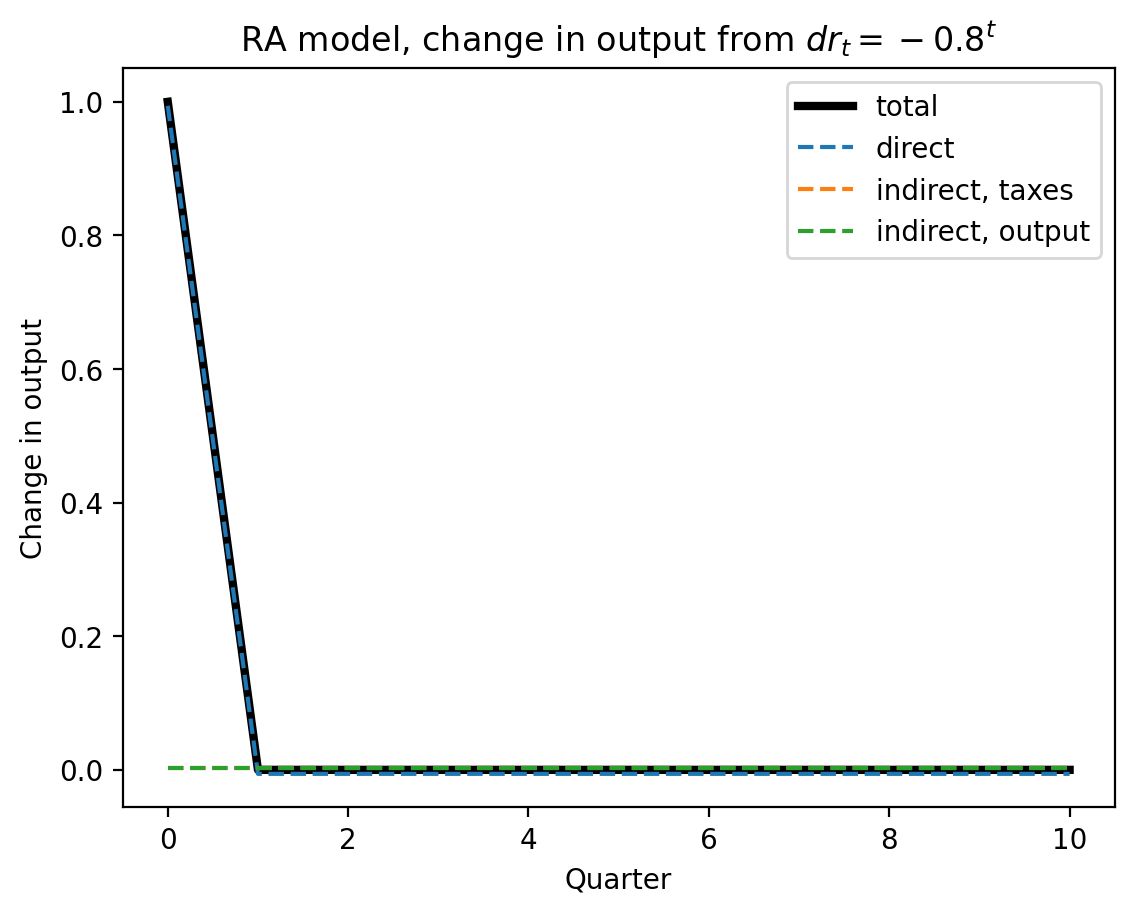

In [111]:
plt.plot(dY_RA[:11], color='k', linewidth=3, label='total')
plt.plot(dY_dir_RA[:11], '--', label='direct')
plt.plot(dY_ind_T[:11], '--', label='indirect, taxes')
plt.plot(dY_ind_Y[:11], '--', label='indirect, output')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('RA model, change in output from $dr_t=-0.8^t$')
plt.legend();

# Same decomposition for TA

Same mu as last time:

In [112]:
mu = 0.32163010311216755
M_TA = mu*np.eye(T) + (1-mu)*M_RA

In [113]:
dY_TA = dY_RA - mu/(1-mu)*dT

"Indirect" tax and output effects:

In [114]:
dY_ind_T = - M_TA @ dT
dY_ind_Y = M_TA @ dY_RA

Remaining "direct" effect:

In [115]:
dY_dir_TA = dY_TA - dY_ind_T - dY_ind_Y

Plot these:

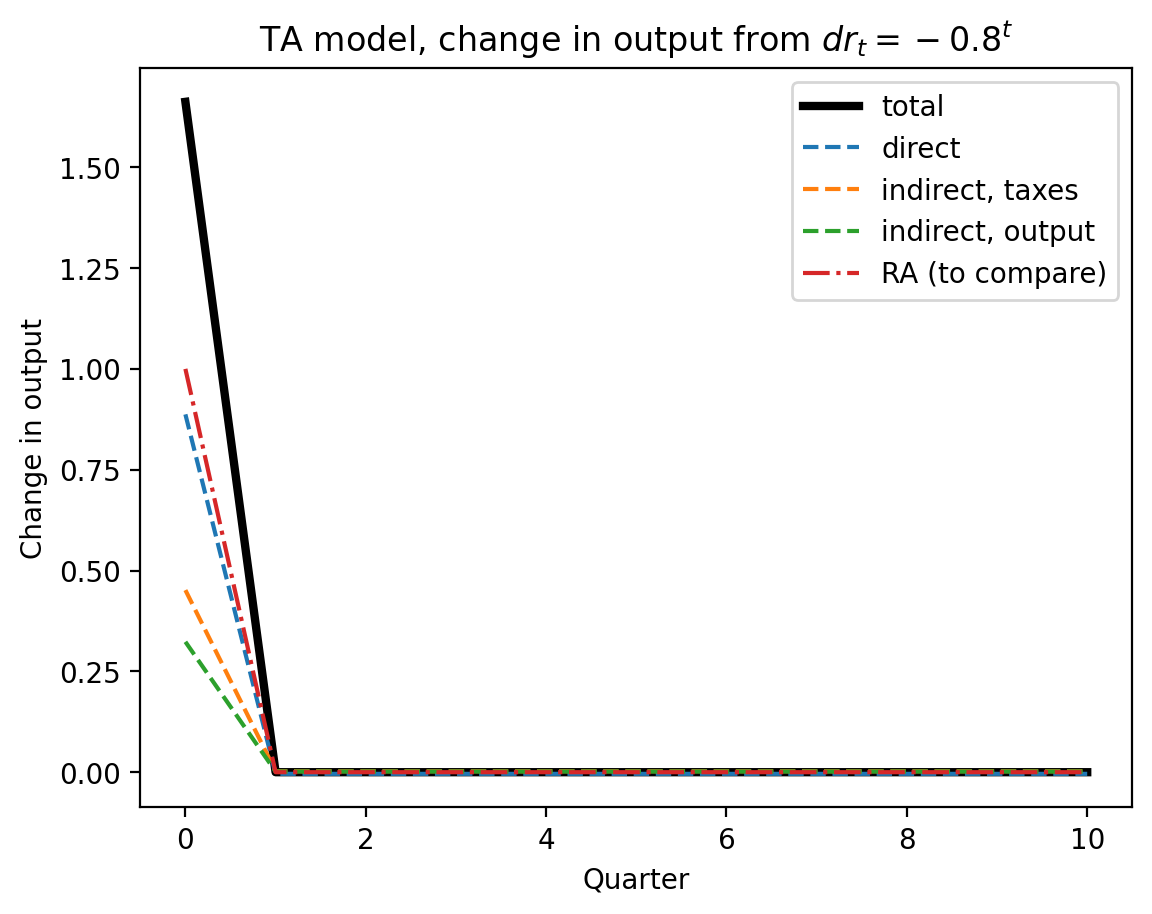

In [116]:
plt.plot(dY_TA[:11], color='k', linewidth=3, label='total')
plt.plot(dY_dir_TA[:11], '--', label='direct')
plt.plot(dY_ind_T[:11], '--', label='indirect, taxes')
plt.plot(dY_ind_Y[:11], '--', label='indirect, output')
plt.plot(dY_RA[:11], '-.', label='RA (to compare)')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('TA model, change in output from $dr_t=-0.8^t$')
plt.legend();

# Same decomposition for HA!

In [117]:
J = jacobian(ss, {'Y': {'y': e}, 'r': {'r': 1}, 'rsub': {'beta': 1+r}}, T+1)
M_HA, A_HA = J['C']['Y'][:T, :T], J['A']['Y'][:T, :T]
Mr_HA, Ar_HA = J['C']['r'][:T, 1:], J['A']['r'][:T, 1:]
Mrsub_HA, Arsub_HA = J['C']['rsub'][:T, :T], J['A']['rsub'][:T, :T]

Find general equilibrium in asset market space:

In [118]:
dB = -dT

In [119]:
dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT

"Indirect" tax and output effects:

In [120]:
dY_ind_T = - M_HA @ dT
dY_ind_Y = M_HA @ dY_HA

Remaining "direct" effect:

In [121]:
dY_dir_HA = dY_HA - dY_ind_T - dY_ind_Y

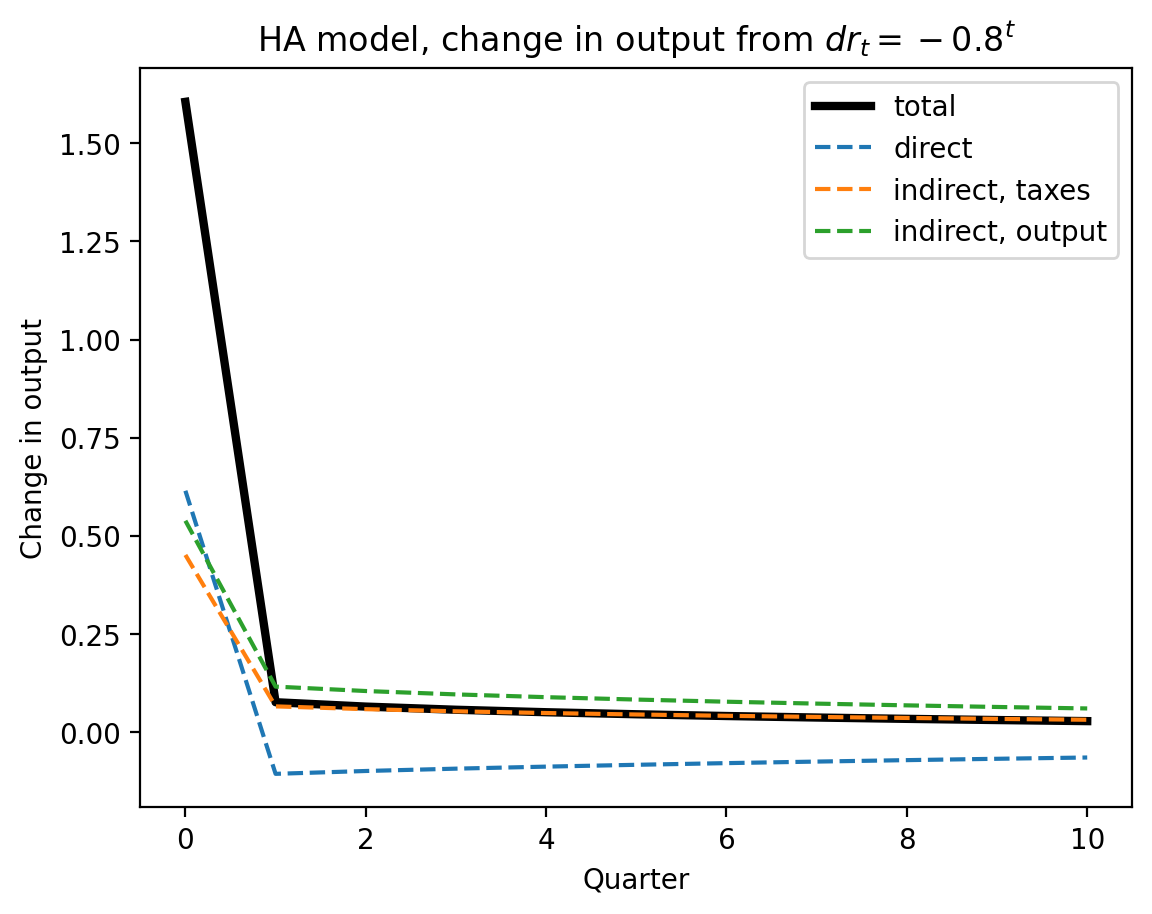

In [122]:
plt.plot(dY_HA[:11], color='k', linewidth=3, label='total')
plt.plot(dY_dir_HA[:11], '--', label='direct')
plt.plot(dY_ind_T[:11], '--', label='indirect, taxes')
plt.plot(dY_ind_Y[:11], '--', label='indirect, output')
# plt.plot(dY_RA[:11], '-.', label='RA (to compare)')
# plt.plot(dY_TA[:11], '-.', label='TA (to compare)')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('HA model, change in output from $dr_t=-0.8^t$')
plt.legend();

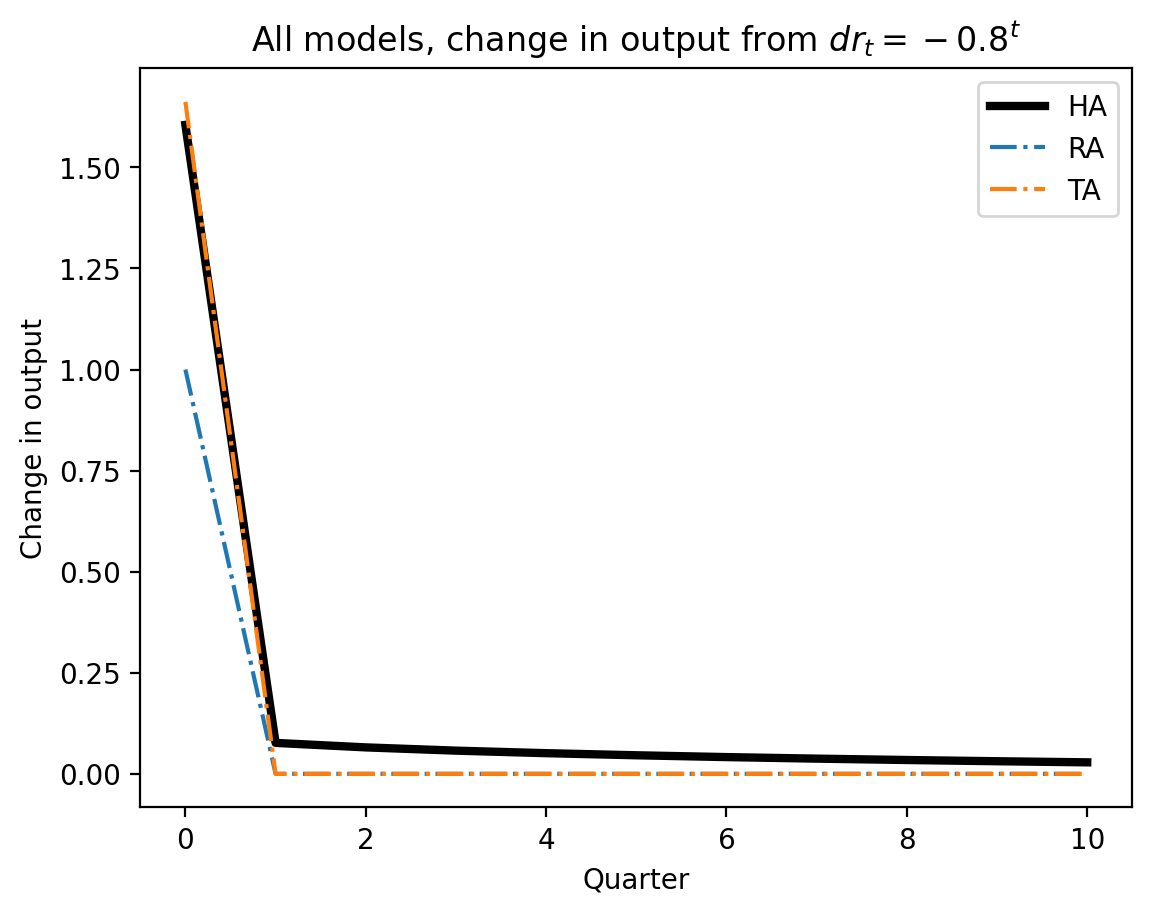

In [123]:
plt.plot(dY_HA[:11], color='k', linewidth=3, label='HA')
plt.plot(dY_RA[:11], '-.', label='RA')
plt.plot(dY_TA[:11], '-.', label='TA')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('All models, change in output from $dr_t=-0.8^t$')
plt.legend();

## Redo this for shocks at different horizons...

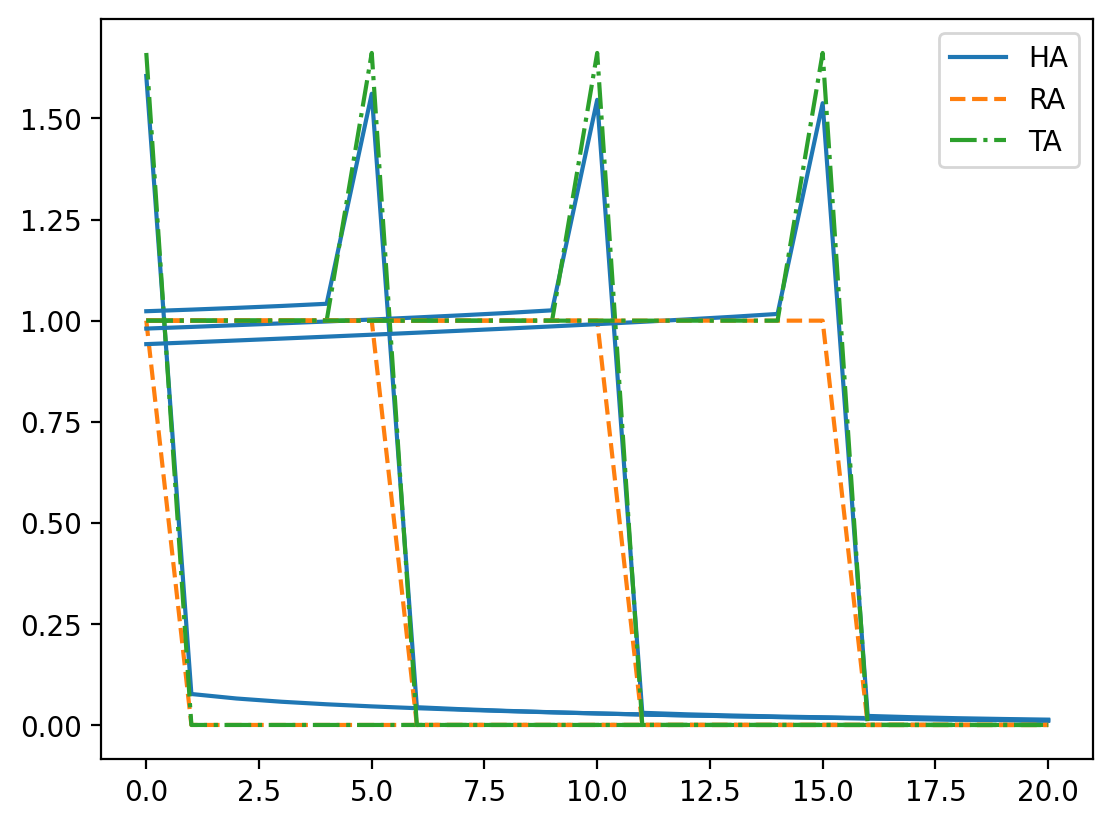

In [124]:
for s in (0, 5, 10, 15):
    dr = -1.*(np.arange(T) == s)
    dT = dr*B / (1+r)
    dB = -dT
    dY_RA = -eis*C* U @ dr
    dY_TA = dY_RA - mu/(1-mu)*dT
    dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
    plt.plot(dY_HA[:21])
    plt.plot(dY_RA[:21], '--')
    plt.plot(dY_TA[:21], '-.')
    plt.gca().set_prop_cycle(None) # reset color cycle
plt.legend(['HA', 'RA', 'TA']);

## Fiscal policy for all three
Specify for a given $\rho$, $dB_t = \rho (dB_{t-1}+ dr_{t-1}B)$.

In [125]:
def fiscal_rule(dr, rho):
    dB = np.empty(T)
    dB[0] = -(1-rho)*dr[0]
    for t in range(1, T):
        dB[t] = rho*(dB[t-1] + dr[t-1]*B)

    dT = -dB.copy()
    dT[1:] += (1+r)*dB[:-1] + dr[:-1]*B
    return dB, dT

Now let's try for $\rho=0.9$ with our oiginal shock.

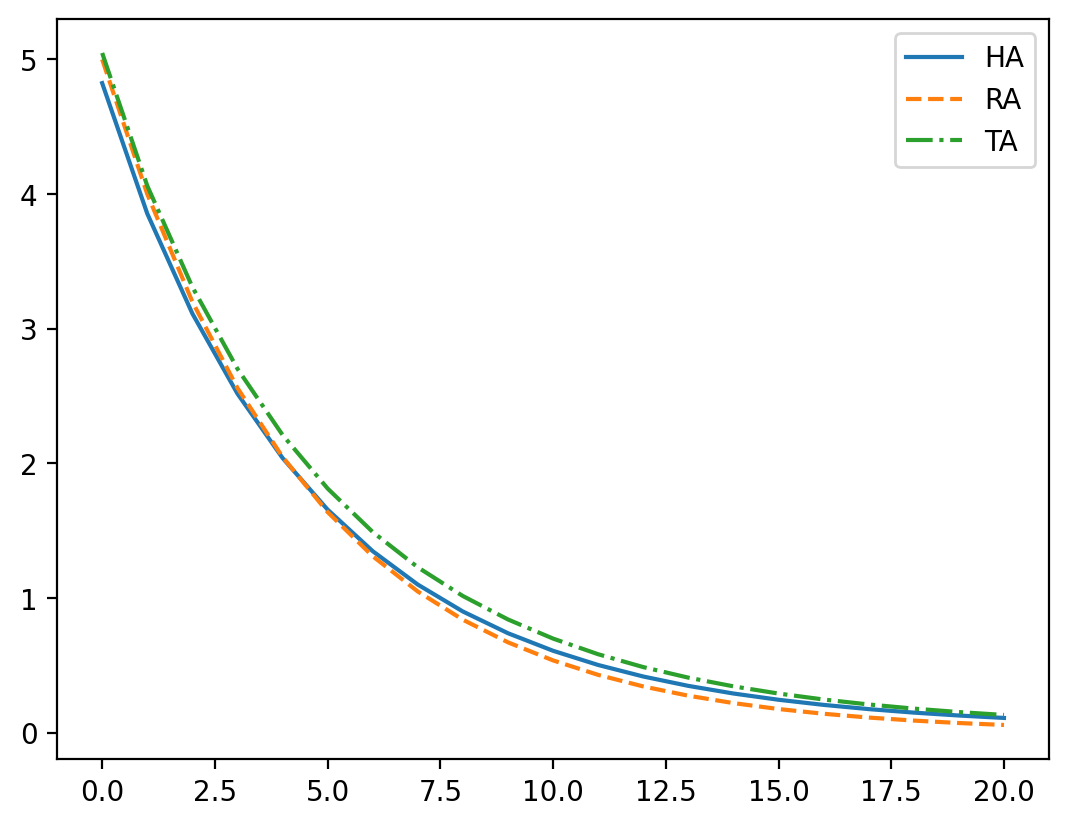

In [126]:
dr = -0.8**np.arange(T)
dB, dT = fiscal_rule(dr, 0.9)
dY_RA = -eis*C* U @ dr
dY_TA = dY_RA - mu/(1-mu)*dT
dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
plt.plot(dY_HA[:21])
plt.plot(dY_RA[:21], '--')
plt.plot(dY_TA[:21], '-.')
plt.legend(['HA', 'RA', 'TA']);

Then $\rho=0.975$:

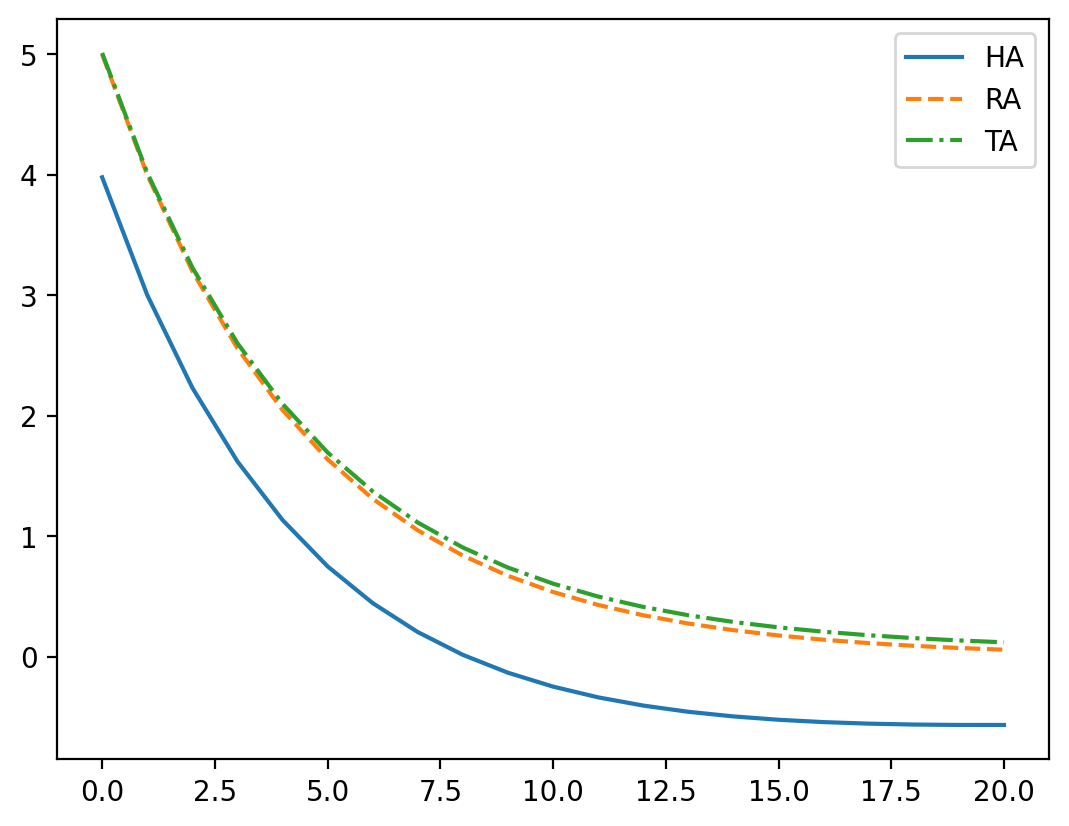

In [127]:
dr = -0.8**np.arange(T)
dB, dT = fiscal_rule(dr, 0.975)
dY_RA = -eis*C* U @ dr
dY_TA = dY_RA - mu/(1-mu)*dT
dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
plt.plot(dY_HA[:21])
plt.plot(dY_RA[:21], '--')
plt.plot(dY_TA[:21], '-.')
plt.legend(['HA', 'RA', 'TA']);

What does the debt itself look like?

Text(0.5, 1.0, 'Path of debt for $\\rho=0.975$')

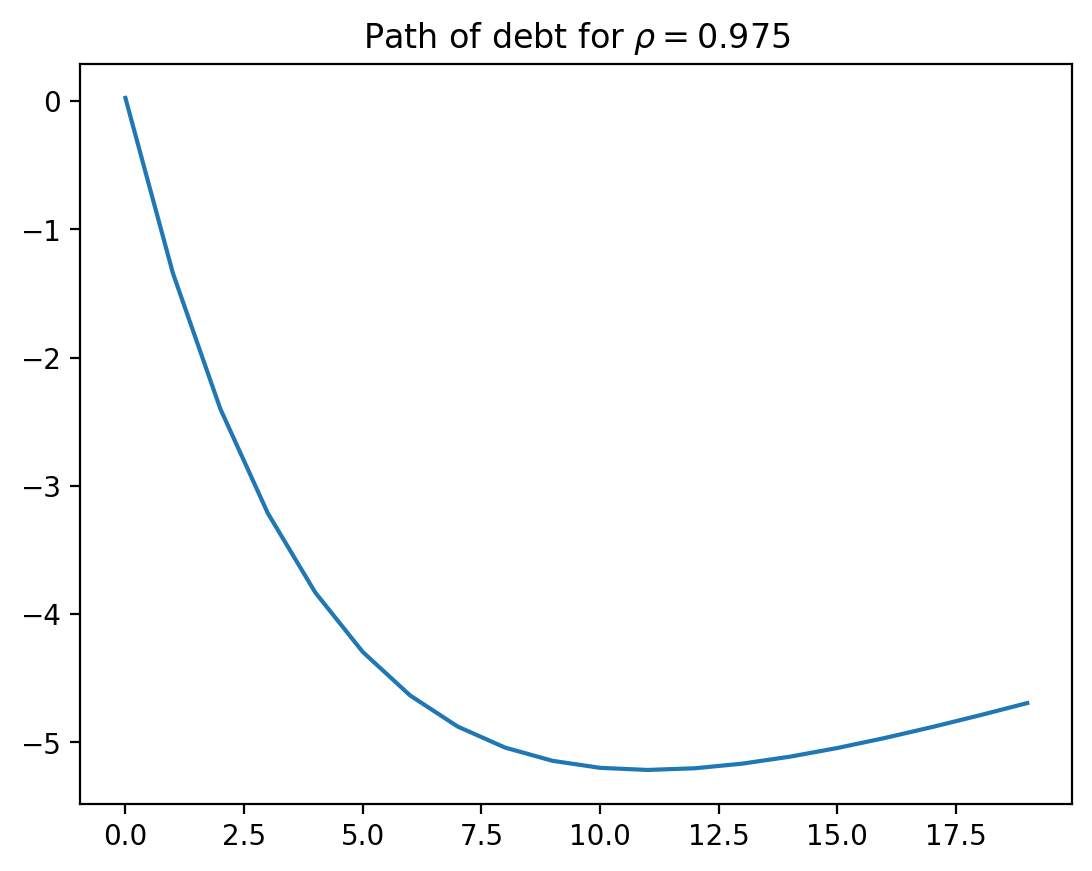

In [128]:
plt.plot(dB[:20])
plt.title(r'Path of debt for $\rho=0.975$')

Redo this again for shocks at all horizons:

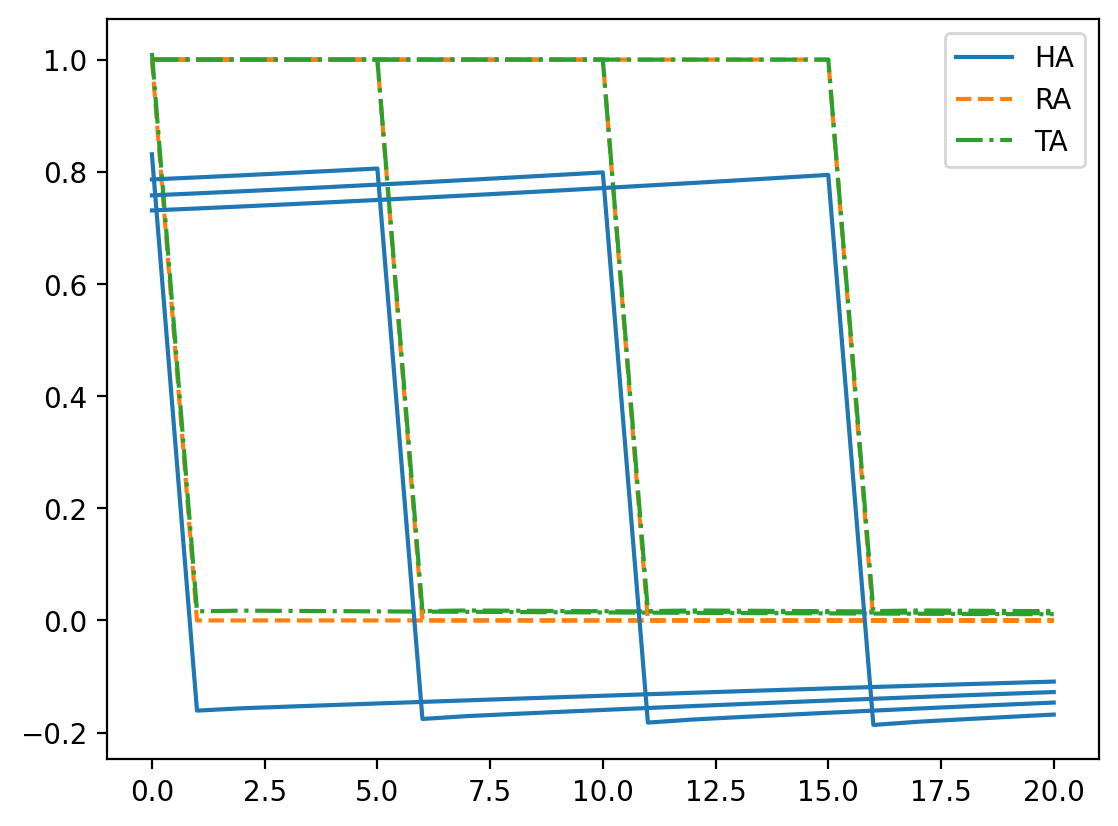

In [129]:
for s in (0, 5, 10, 15):
    dr = -1.*(np.arange(T) == s)
    dB, dT = fiscal_rule(dr, 0.975)
    dY_RA = -eis*C* U @ dr
    dY_TA = dY_RA - mu/(1-mu)*dT
    dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
    plt.plot(dY_HA[:21])
    plt.plot(dY_RA[:21], '--')
    plt.plot(dY_TA[:21], '-.')
    plt.gca().set_prop_cycle(None) # reset color cycle
plt.legend(['HA', 'RA', 'TA']);

# Substitution vs. income effects
Back to our original calibration and HA decomposition.

In [130]:
dr = -0.8**np.arange(T)
dT = dr*B / (1+r)
dB = -dT
dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
dY_ind_T = - M_HA @ dT
dY_ind_Y = M_HA @ dY_HA
dY_dir_HA = dY_HA - dY_ind_T - dY_ind_Y

Verify that "direct" effect is also what we can get from $dr$ and $M^r$:

In [131]:
np.max(np.abs(Mr_HA @ dr  - dY_dir_HA))

1.298238405667007e-09

Now let's get the substitution and income effects:

In [132]:
dY_dir_sub = Mrsub_HA @ dr
dY_dir_inc = dY_dir_HA - dY_dir_sub

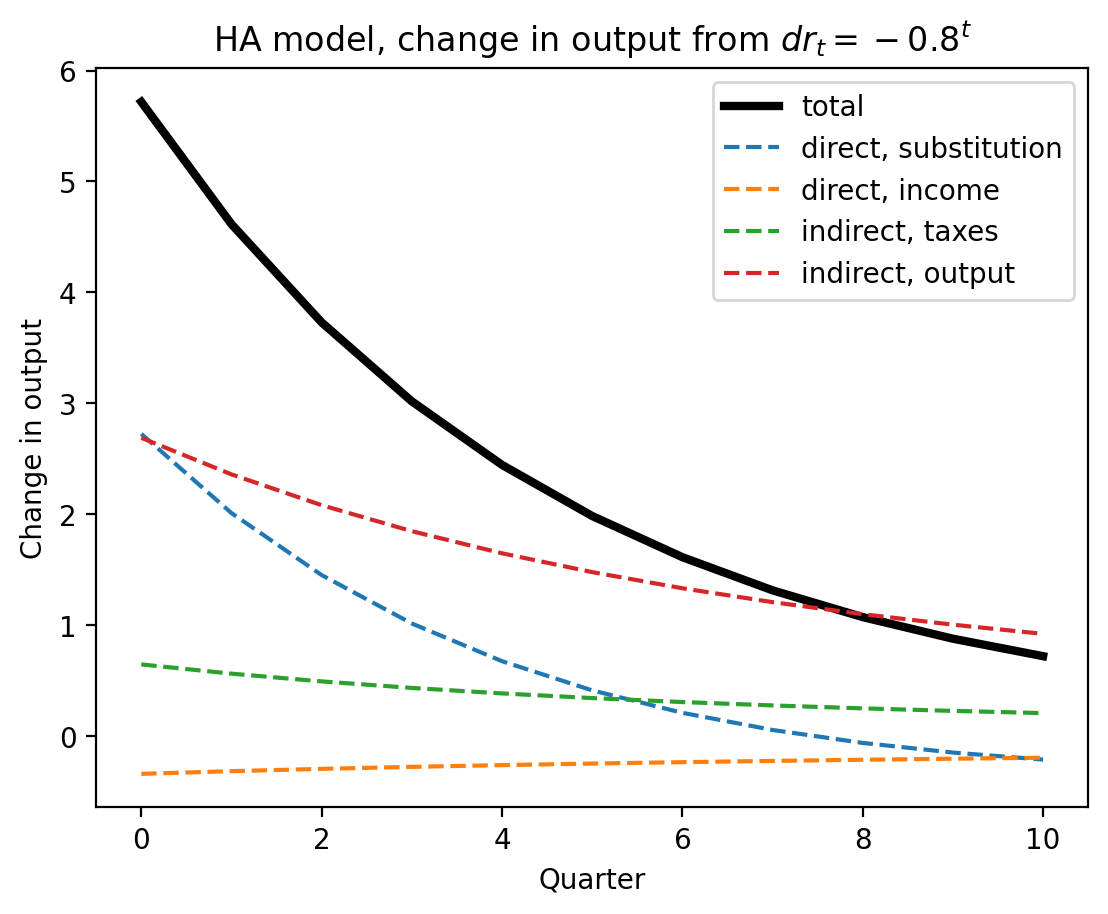

In [133]:
plt.plot(dY_HA[:11], color='k', linewidth=3, label='total')
plt.plot(dY_dir_sub[:11], '--', label='direct, substitution')
plt.plot(dY_dir_inc[:11], '--', label='direct, income')
plt.plot(dY_ind_T[:11], '--', label='indirect, taxes')
plt.plot(dY_ind_Y[:11], '--', label='indirect, output')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('HA model, change in output from $dr_t=-0.8^t$')
plt.legend();

# General equilibrium decomposition

In [134]:
Arinc_HA = Ar_HA - Arsub_HA
dY_HA_sub = np.linalg.solve(A_HA, - Arsub_HA @ dr)
dY_HA_inc_tax = np.linalg.solve(A_HA, dB - Arinc_HA @ dr) + dT

Verify that we've done the decomposition correctly:

In [135]:
np.allclose(dY_HA, dY_HA_sub + dY_HA_inc_tax)

True

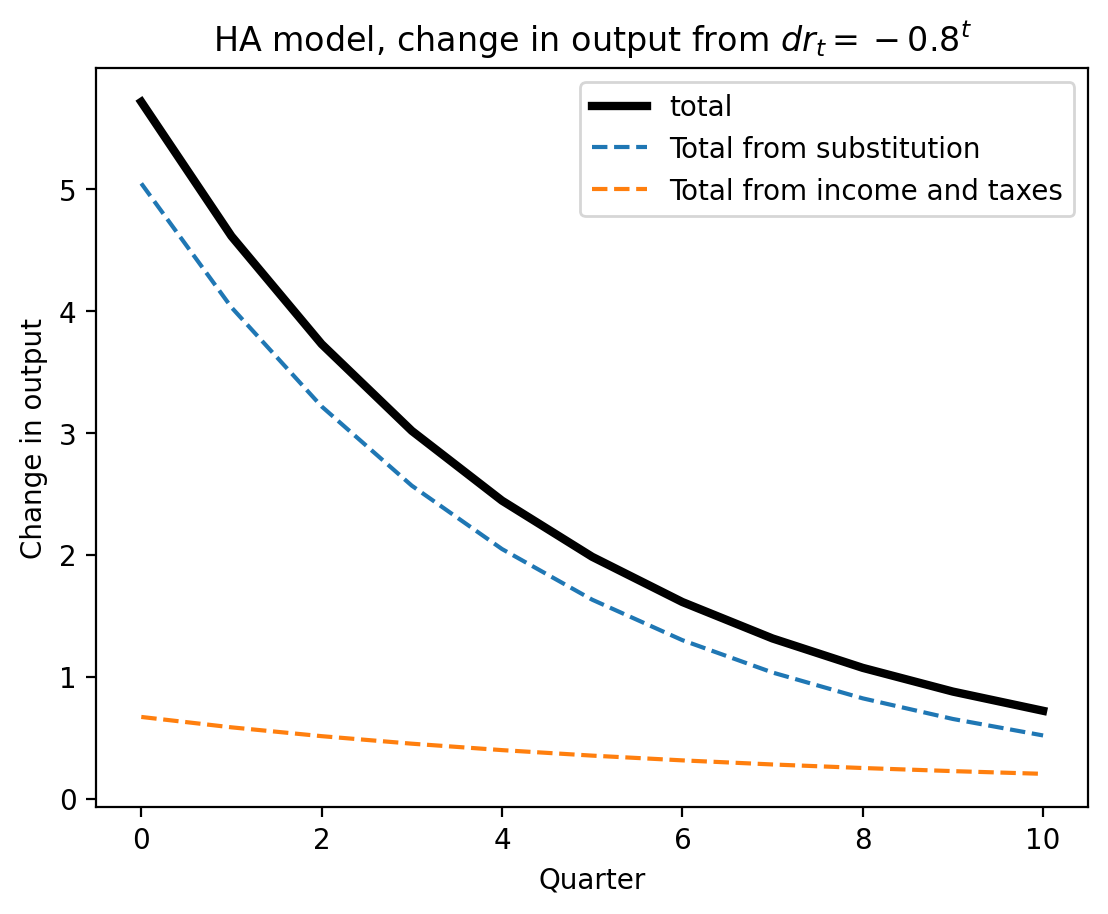

In [136]:
plt.plot(dY_HA[:11], color='k', linewidth=3, label='total')
plt.plot(dY_HA_sub[:11], '--', label='Total from substitution')
plt.plot(dY_HA_inc_tax[:11], '--', label='Total from income and taxes')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('HA model, change in output from $dr_t=-0.8^t$')
plt.legend();

Alternative one that generalizes what we had before:

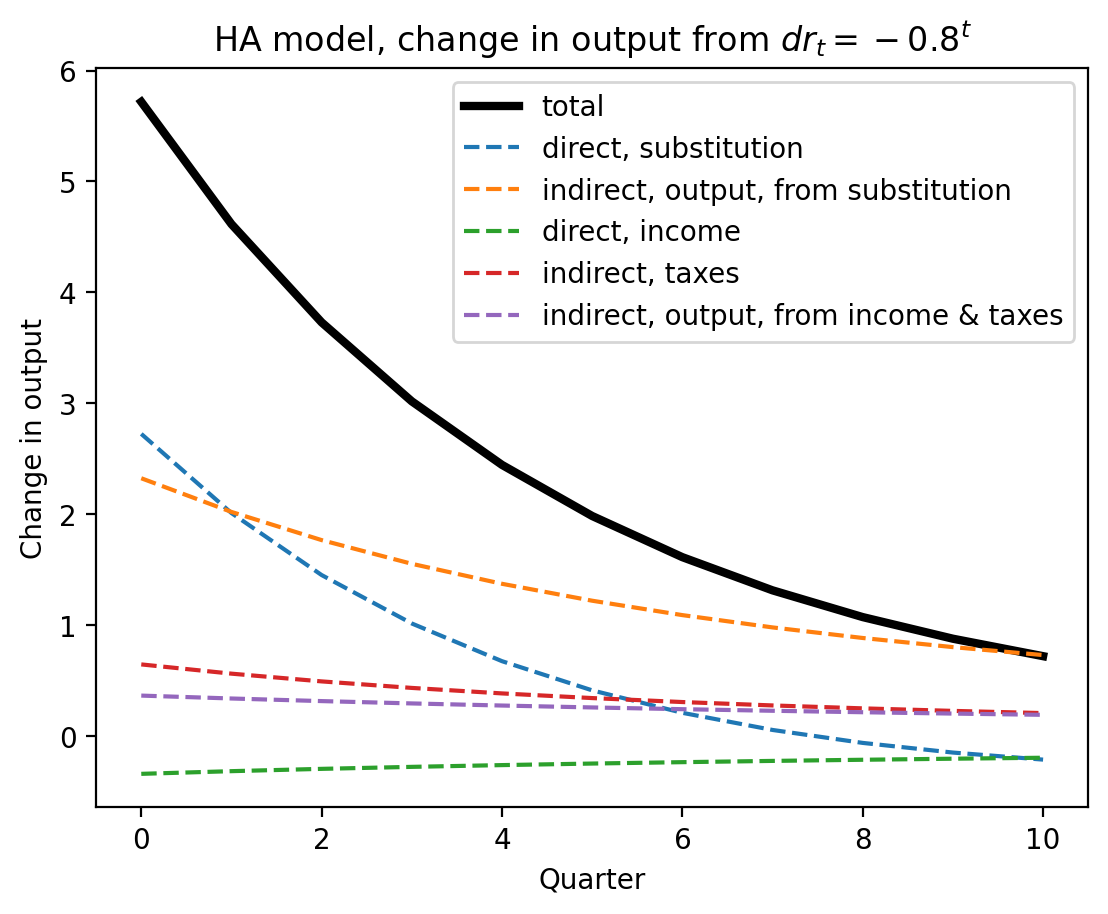

In [137]:
plt.plot(dY_HA[:11], color='k', linewidth=3, label='total')
plt.plot(dY_dir_sub[:11], '--', label='direct, substitution')
plt.plot((dY_HA_sub - dY_dir_sub)[:11], '--', label='indirect, output, from substitution')
plt.plot(dY_dir_inc[:11], '--', label='direct, income')
plt.plot(dY_ind_T[:11], '--', label='indirect, taxes')
plt.plot((dY_HA_inc_tax-dY_dir_inc-dY_ind_T)[:11], '--', label='indirect, output, from income & taxes')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('HA model, change in output from $dr_t=-0.8^t$')
plt.legend();

# Myopia

In [138]:
M_HA_myo, A_HA_myo = np.tril(linalg.toeplitz(M_HA[:, 0])), np.tril(linalg.toeplitz(A_HA[:, 0]))
M_HA_myo[:4, :4]

array([[0.3233218 , 0.        , 0.        , 0.        ],
       [0.0472595 , 0.3233218 , 0.        , 0.        ],
       [0.04215273, 0.0472595 , 0.3233218 , 0.        ],
       [0.03829247, 0.04215273, 0.0472595 , 0.3233218 ]])

In [139]:
dY_HA_myo = np.linalg.solve(A_HA_myo, dB - Ar_HA @ dr) + dT

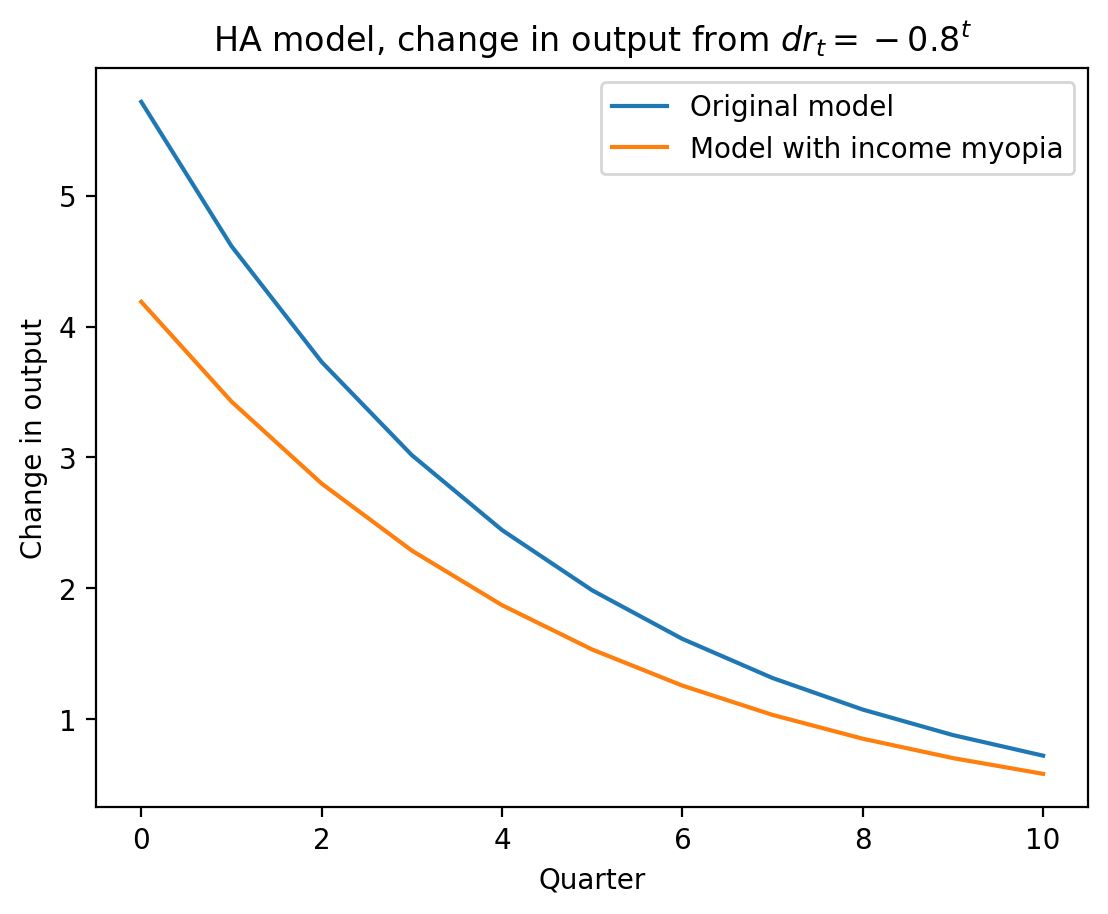

In [140]:
plt.plot(dY_HA[:11])
plt.plot(dY_HA_myo[:11])
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('HA model, change in output from $dr_t=-0.8^t$')
plt.legend(['Original model', 'Model with income myopia']);

Can we calculate the same thing by M matrix?

In [141]:
dY_HA_myo_alt = np.linalg.solve(np.eye(T) - M_HA_myo, dY_dir_HA - M_HA_myo @ dT)
np.allclose(dY_HA_myo, dY_HA_myo_alt)

True

Let's do it also for RA and TA, then.

In [142]:
M_RA_myo = np.tril(linalg.toeplitz(M_RA[:, 0]))
M_TA_myo = np.tril(linalg.toeplitz(M_TA[:, 0]))

In [143]:
dY_RA = -eis*C* U @ dr
dY_TA = dY_RA - mu/(1-mu)*dT
dY_RA_myo = np.linalg.solve(np.eye(T) - M_RA_myo, dY_dir_RA - M_RA_myo @ dT)
dY_TA_myo = np.linalg.solve(np.eye(T) - M_TA_myo, dY_dir_TA - M_TA_myo @ dT)

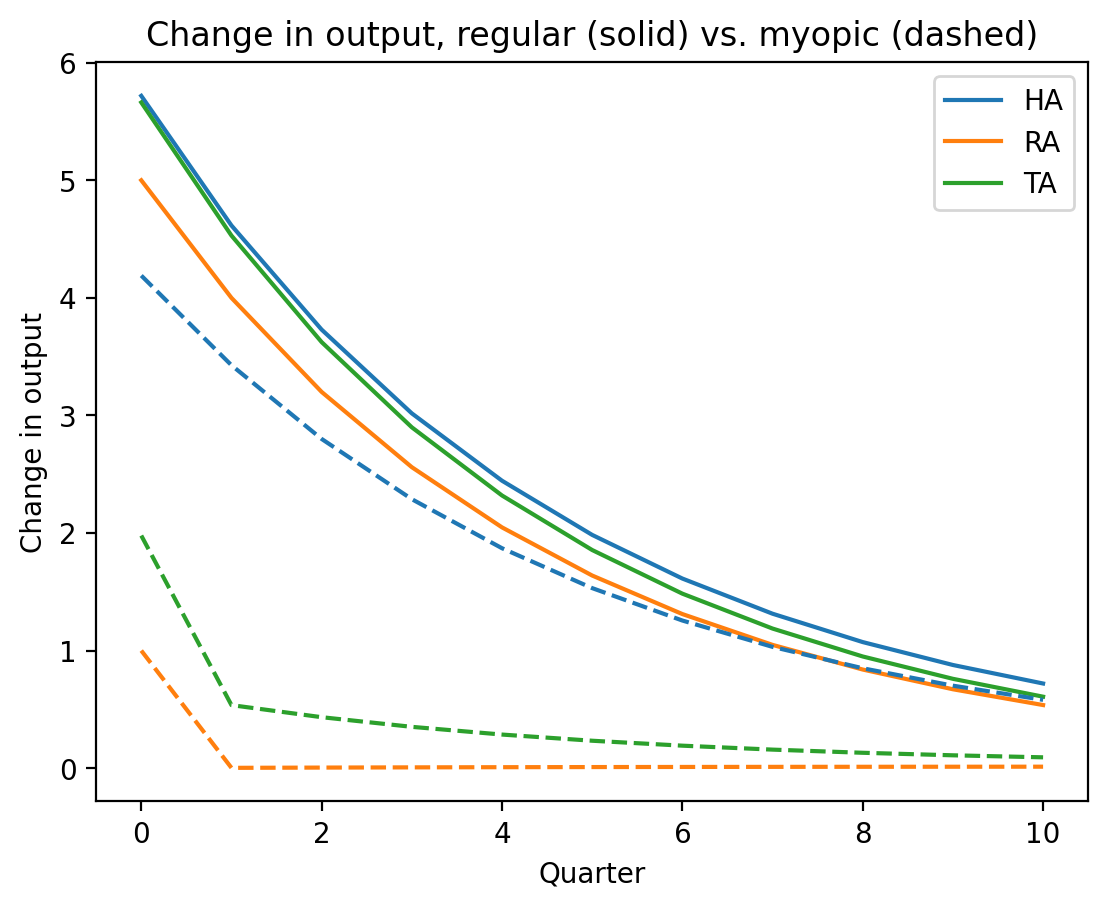

In [144]:
plt.plot(dY_HA[:11], label='HA')
plt.plot(dY_RA[:11], label='RA')
plt.plot(dY_TA[:11], label='TA')
plt.gca().set_prop_cycle(None) # reset color cycle
plt.plot(dY_HA_myo[:11], '--')
plt.plot(dY_RA_myo[:11], '--')
plt.plot(dY_TA_myo[:11], '--')
plt.ylabel('Change in output')
plt.xlabel('Quarter')
plt.title('Change in output, regular (solid) vs. myopic (dashed)')
plt.legend();

Let's do this for forward guidance too:

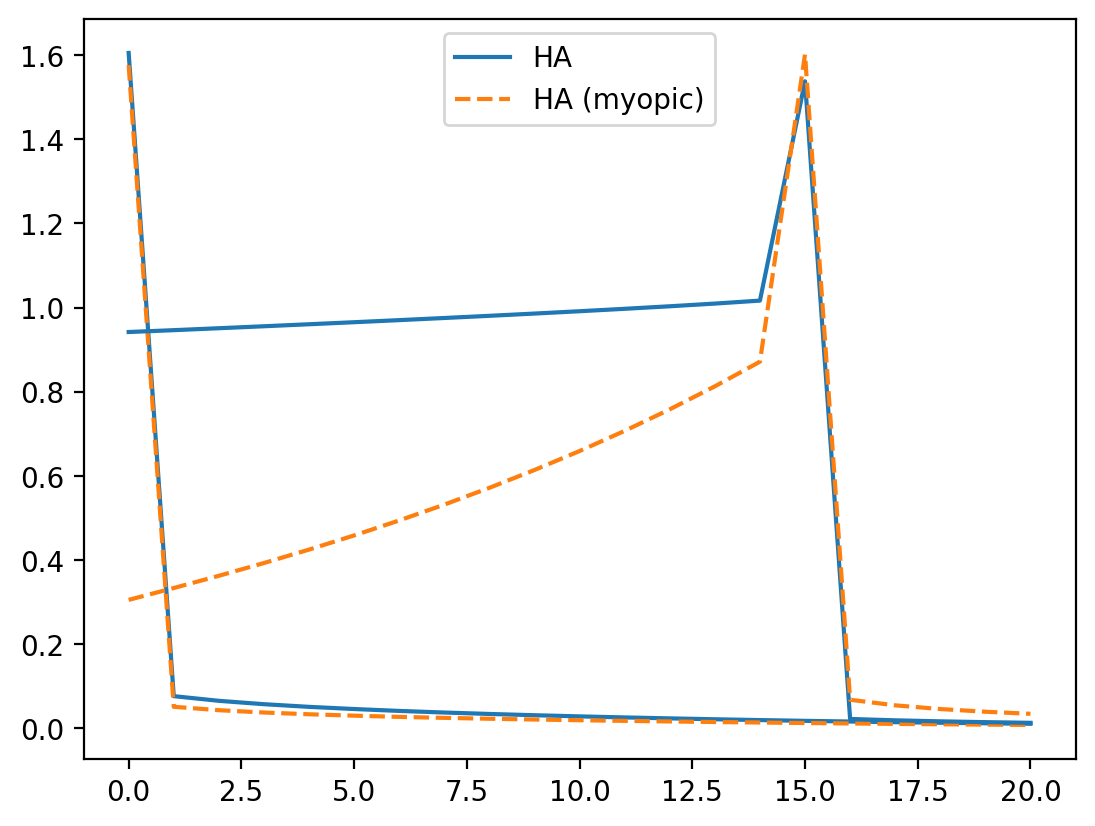

In [145]:
for s in (0, 15):
    dr = -1.*(np.arange(T) == s)
    dB = -dr/(1+r)*B
    dT = -dB
    dY_HA = np.linalg.solve(A_HA, dB - Ar_HA @ dr) + dT
    dY_HA_myo = np.linalg.solve(A_HA_myo, dB - Ar_HA @ dr) + dT
    plt.plot(dY_HA[:21])
    plt.plot(dY_HA_myo[:21], '--')
    plt.gca().set_prop_cycle(None) # reset color cycle
plt.legend(['HA', 'HA (myopic)']);